<a href="https://colab.research.google.com/github/aslestia/ACS_2025/blob/main/ACS_week1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  5 of 5 completed


Data shape (T x K): (1416, 5)
Ticker          AAPL      MSFT      TSLA     GOOGL      NFLX
Date                                                        
2020-01-03 -0.009722 -0.012452  0.029633 -0.005231 -0.011855
2020-01-06  0.007968  0.002585  0.019255  0.026654  0.030469
2020-01-07 -0.004703 -0.009118  0.038801 -0.001932 -0.015127
2020-01-08  0.016087  0.015928  0.049205  0.007118  0.025729
2020-01-09  0.021241  0.012493 -0.021945  0.010498 -0.010611

=== EDA: deskriptif return (head) ===
         count      mean       std       min       25%       50%       75%  \
Ticker                                                                       
AAPL    1416.0  0.001007  0.020420 -0.128647 -0.008509  0.001119  0.011747   
MSFT    1416.0  0.001023  0.018993 -0.147390 -0.008016  0.001044  0.010696   
TSLA    1416.0  0.002608  0.042603 -0.210628 -0.020337  0.001620  0.023847   
GOOGL   1416.0  0.000971  0.020491 -0.116341 -0.009540  0.001643  0.011605   
NFLX    1416.0  0.001322  0.028017 -

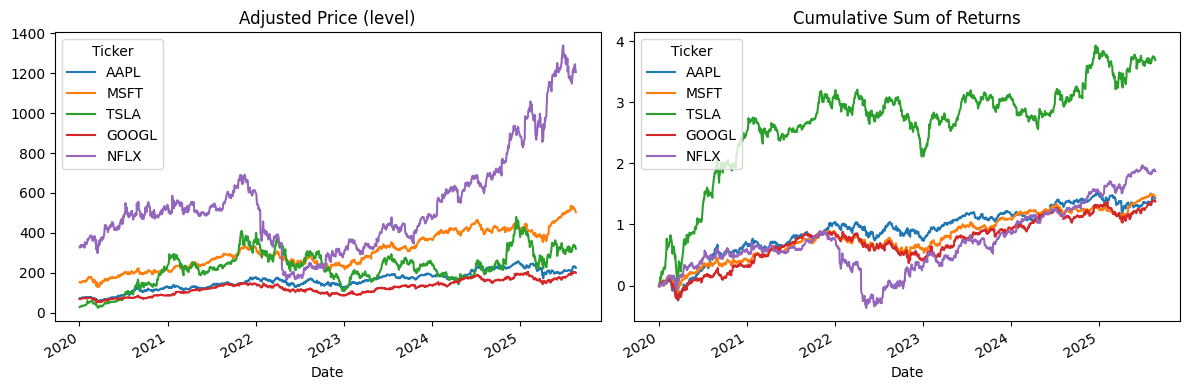


Best fixed arm by mean: TSLA (mean=0.002608)

=== Ringkasan akhir ===
{'eg_final_cum': np.float64(4.088130612403451), 'uc_final_cum': np.float64(2.7137860440699937), 'eg_final_regret': np.float64(-0.3954238922285751), 'uc_final_regret': np.float64(0.9789206761048823)}


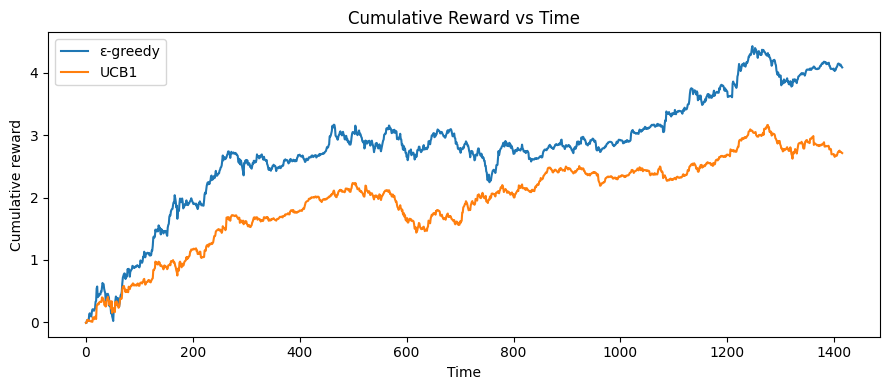

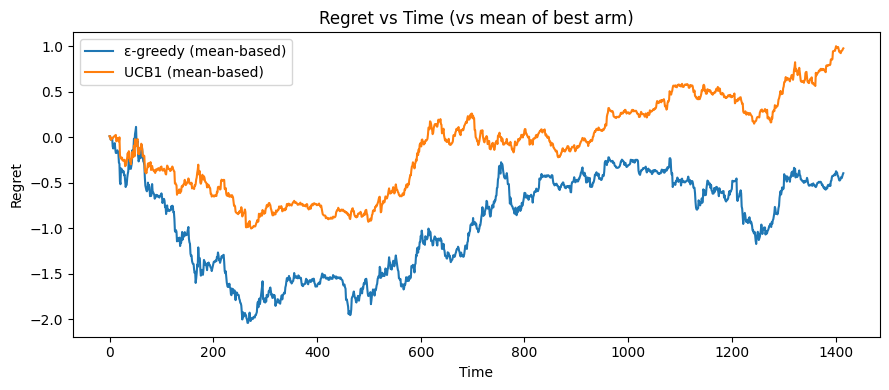

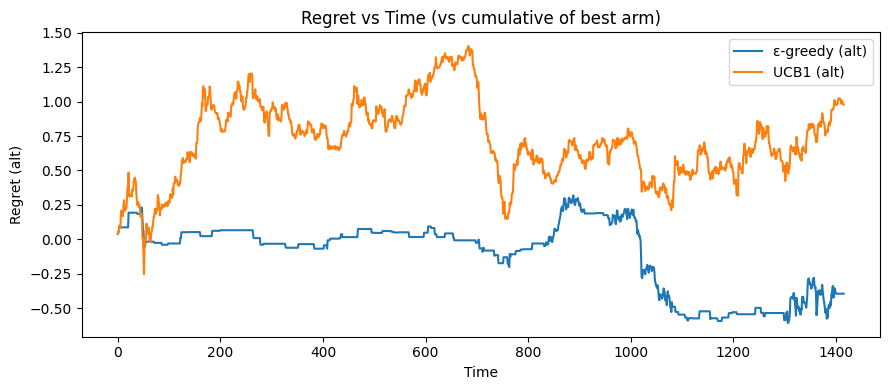


Pemilihan arm (ε-greedy): {'AAPL': np.int64(30), 'MSFT': np.int64(58), 'TSLA': np.int64(1032), 'GOOGL': np.int64(30), 'NFLX': np.int64(266)}
Pemilihan arm (UCB1):     {'AAPL': np.int64(283), 'MSFT': np.int64(275), 'TSLA': np.int64(292), 'GOOGL': np.int64(277), 'NFLX': np.int64(289)}


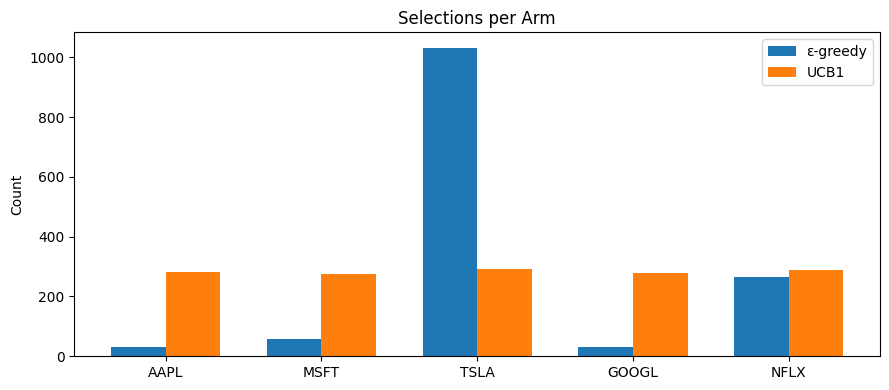

In [2]:
# ===========================
# WEEK 1 — Multi-Armed Bandit (Finance)
# AAPL, MSFT, TSLA, GOOGL, NFLX
# ===========================

!pip install yfinance

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# ---------- 0) PARAMETER ----------
TICKERS = ["AAPL","MSFT","TSLA","GOOGL","NFLX"]  # saham
START   = "2020-01-01"
END     = None           # None = sampai hari ini
FREQ    = "1d"           # "1d" (harian) atau "1wk" (mingguan)
USE_LOG = False          # False -> simple return; True -> log-return

SEED          = 42
EPSILON       = 0.10     # untuk ε-greedy
UCB_C         = np.sqrt(2.0)  # koefisien eksplorasi UCB1
INIT_EPS_ALL  = True     # ε-greedy: coba semua arm sekali di awal

np.random.seed(SEED)

# ---------- 1) DOWNLOAD & SIAPKAN DATA ----------
raw = yf.download(TICKERS, start=START, end=END, interval=FREQ, auto_adjust=False)["Adj Close"]
if isinstance(raw, pd.Series):  # kalau hanya 1 kolom
    raw = raw.to_frame()
raw = raw.dropna(how="all").sort_index()

# hitung return
if USE_LOG:
    ret = np.log(raw).diff().dropna()
else:
    ret = raw.pct_change().dropna()

# rapikan kolom & index
ret = ret[TICKERS].dropna()

print("Data shape (T x K):", ret.shape)
print(ret.head())

# ---------- 2) EDA RINGKAS ----------
print("\n=== EDA: deskriptif return (head) ===")
print(ret.describe().T)

print("\n=== EDA: korelasi return ===")
print(ret.corr())

# Plot harga & return singkat
fig, ax = plt.subplots(1,2, figsize=(12,4))
raw[TICKERS].dropna().plot(ax=ax[0], title="Adjusted Price (level)")
ret[TICKERS].cumsum().plot(ax=ax[1], title="Cumulative Sum of Returns")
plt.tight_layout(); plt.show()

# ---------- 3) SIAPKAN MATRIX REWARD ----------
R = ret.values  # shape (T, K)
dates = ret.index
T, K = R.shape
arms = TICKERS

# helper untuk regret
def best_fixed_arm_mean(R):
    m = R.mean(axis=0)
    j = int(np.argmax(m))
    return j, float(m[j])

j_star, mu_star = best_fixed_arm_mean(R)
print(f"\nBest fixed arm by mean: {arms[j_star]} (mean={mu_star:.6f})")

# ---------- 4) ALGORITMA MAB ----------
def run_epsilon_greedy(R, epsilon=0.1, init_rounds=True, seed=42):
    rng = np.random.default_rng(seed)
    T, K = R.shape
    counts = np.zeros(K, dtype=int)
    means  = np.zeros(K, dtype=float)
    chosen, rewards = [], []

    t0 = 0
    if init_rounds:
        t0 = min(K, T)
        for t in range(t0): # Corrected: Iterate through time steps
            a = t # In initialization, arm index is same as time step
            r = R[t, a] # Corrected: Use time index t
            counts[a] += 1
            means[a] += (r - means[a]) / counts[a]
            chosen.append(a); rewards.append(r)

    for t in range(t0, T):
        if rng.random() < epsilon:
            a = rng.integers(0, K)              # eksplor
        else:
            a = int(np.argmax(means))           # eksploit
        r = R[t, a]
        counts[a] += 1
        means[a] += (r - means[a]) / counts[a]
        chosen.append(a); rewards.append(r)

    return np.array(chosen), np.array(rewards)

def run_ucb1(R, c=np.sqrt(2.0)):
    T, K = R.shape
    counts = np.zeros(K, dtype=int)
    means  = np.zeros(K, dtype=float)
    chosen, rewards = [], []

    # inisialisasi: mainkan semua arm sekali
    for t in range(min(K, T)): # Corrected: Iterate through time steps
        a = t # In initialization, arm index is same as time step
        r = R[t, a] # Corrected: Use time index t
        counts[a] = 1
        means[a]  = r
        chosen.append(a); rewards.append(r)

    for t in range(K, T):
        bonus = c * np.sqrt(np.log(t+1) / np.maximum(1, counts))
        ucb = means + bonus
        a = int(np.argmax(ucb))
        r = R[t, a]
        counts[a] += 1
        means[a]  += (r - means[a]) / counts[a]
        chosen.append(a); rewards.append(r)

    return np.array(chosen), np.array(rewards)

# jalankan
eg_choice, eg_reward = run_epsilon_greedy(R, EPSILON, INIT_EPS_ALL, SEED)
uc_choice, uc_reward = run_ucb1(R, UCB_C)

# ---------- 5) EVALUASI ----------
def cumulative_regret(rewards, mu_star):
    t = np.arange(1, len(rewards)+1)
    return t * mu_star - np.cumsum(rewards)

eg_cum = np.cumsum(eg_reward)
uc_cum = np.cumsum(uc_reward)

eg_reg = cumulative_regret(eg_reward, mu_star)
uc_reg = cumulative_regret(uc_reward, mu_star)

# alternatif regret “robust”: bandingkan ke cumulative dari arm terbaik aktual
best_cum = np.cumsum(R[:, j_star])
eg_reg_alt = best_cum - np.cumsum(eg_reward)
uc_reg_alt = best_cum - np.cumsum(uc_reward)

# ---------- 6) RINGKASAN & PLOT ----------
print("\n=== Ringkasan akhir ===")
print({
    "eg_final_cum": eg_cum[-1],
    "uc_final_cum": uc_cum[-1],
    "eg_final_regret": eg_reg[-1],
    "uc_final_regret": uc_reg[-1],
})

# Plot cumulative reward
plt.figure(figsize=(9,4))
plt.plot(eg_cum, label="ε-greedy")
plt.plot(uc_cum, label="UCB1")
plt.title("Cumulative Reward vs Time")
plt.xlabel("Time"); plt.ylabel("Cumulative reward")
plt.legend(); plt.tight_layout(); plt.show()

# Plot regret (dua versi)
plt.figure(figsize=(9,4))
plt.plot(eg_reg, label="ε-greedy (mean-based)")
plt.plot(uc_reg, label="UCB1 (mean-based)")
plt.title("Regret vs Time (vs mean of best arm)")
plt.xlabel("Time"); plt.ylabel("Regret")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4))
plt.plot(eg_reg_alt, label="ε-greedy (alt)")
plt.plot(uc_reg_alt, label="UCB1 (alt)")
plt.title("Regret vs Time (vs cumulative of best arm)")
plt.xlabel("Time"); plt.ylabel("Regret (alt)")
plt.legend(); plt.tight_layout(); plt.show()

# Frekuensi pemilihan arm
eg_counts = np.bincount(eg_choice, minlength=K)
uc_counts = np.bincount(uc_choice, minlength=K)

print("\nPemilihan arm (ε-greedy):", dict(zip(arms, eg_counts)))
print("Pemilihan arm (UCB1):    ", dict(zip(arms, uc_counts)))

plt.figure(figsize=(9,4))
x = np.arange(K)
w = 0.35
plt.bar(x - w/2, eg_counts, width=w, label="ε-greedy")
plt.bar(x + w/2, uc_counts, width=w, label="UCB1")
plt.xticks(x, arms)
plt.title("Selections per Arm")
plt.ylabel("Count"); plt.legend()
plt.tight_layout(); plt.show()